In [1]:
from fastai import *
from fastai.vision.all import *
from fastai.vision.core import *
from fastai.data.transforms import *
from fastai.callback.core import *
import torch
from pathlib import Path
import numpy as np
import cv2
import os
import sys
import shutil
import re
import gc
import matplotlib.pyplot as plt
from segmentation_data import *
import pandas as pd
from classifier_common import *

In [2]:
# data_dir = Path("/data/datasets/Mendeley_Curated_Masked")
data_dir = Path("/data/datasets/extended_v2_Masked")
train_dir = data_dir/"train"
regions_csv = "/data/datasets/extended_v2_Masked/regions.csv"
model_path = "/data/output/pytorch-extended_v2-20201105_01"
model_dir = "resnet34"
base_arch = resnet34

regions_df = pd.read_csv(regions_csv, index_col=0, dtype={"file": str})
regions_df

x  \
file                                                                                                           
/data/datasets/extended_v2_Masked/train/Pneumonia/SARS-10.1148rg.242035193-g04mr34g0-Fig8a-day0.jpeg       0   
/data/datasets/extended_v2_Masked/train/Pneumonia/SARS-10.1148rg.242035193-g04mr34g0-Fig8b-day5.jpeg       0   
/data/datasets/extended_v2_Masked/train/Pneumonia/SARS-10.1148rg.242035193-g04mr34g0-Fig8c-day10.jpeg      0   
/data/datasets/extended_v2_Masked/train/Pneumonia/SARS-10.1148rg.242035193-g04mr34g04a-Fig4a-day7.jpeg     0   
/data/datasets/extended_v2_Masked/train/Pneumonia/SARS-10.1148rg.242035193-g04mr34g04b-Fig4b-day12.jpeg    0   
...                                                                                                      ...   
/data/datasets/extended_v2_Masked/evaluate/COVID-19/COVID-19-AR-16434409_01.png                          356   
/data/datasets/extended_v2_Masked/evaluate/COVID-19/COVID-19-AR-16434444_01.png                          368   
/data/datasets/extended_v2_Masked/evaluate/COVID-19/COVID-19-AR-16434444_02.png                          343   
/data/datasets/extended_v2_Masked/evaluate/COVID-19/COVID-19-AR-16445122_01.png                          546   
/data/datasets/extended_v2_Masked/evaluate/COVID-19/COVID-19-AR-16445143_01.png                          203   

                                                                                                           y  \
file                                                                                                           
/data/datasets/extended_v2_Masked/train/Pneumonia/SARS-10.1148rg.242035193-g04mr34g0-Fig8a-day0.jpeg      59   
/data/datasets/extended_v2_Masked/train/Pneumonia/SARS-10.1148rg.242035193-g04mr34g0-Fig8b-day5.jpeg       0   
/data/datasets/extended_v2_Masked/train/Pneumonia/SARS-10.1148rg.242035193-g04mr34g0-Fig8c-day10.jpeg     20   
/data/datasets/extended_v2_Masked/train/Pneumonia/SARS-10.1148rg.242035193-g04mr34g04a-Fig4a-day7.jpeg    32   
/data/datasets/extended_v2_Masked/train/Pneumonia/SARS-10.1148rg.242035193-g04mr34g04b-Fig4b-day12.jpeg    7   
...                                                                                                      ...   
/data/datasets/extended_v2_Masked/evaluate/COVID-19/COVID-19-AR-16434409_01.png                          422   
/data/datasets/extended_v2_Masked/evaluate/COVID-19/COVID-19-AR-16434444_01.png                          322   
/data/datasets/extended_v2_Masked/evaluate/COVID-19/COVID-19-AR-16434444_02.png                          468   
/data/datasets/extended_v2_Masked/evaluate/COVID-19/COVID-19-AR-16445122_01.png                          235   
/data/datasets/extended_v2_Masked/evaluate/COVID-19/COVID-19-AR-16445143_01.png                          176   

                                                                                                         width  \
file                                                                                                             
/data/datasets/extended_v2_Masked/train/Pneumonia/SARS-10.1148rg.242035193-g04mr34g0-Fig8a-day0.jpeg      1692   
/data/datasets/extended_v2_Masked/train/Pneumonia/SARS-10.1148rg.242035193-g04mr34g0-Fig8b-day5.jpeg      1800   
/data/datasets/extended_v2_Masked/train/Pneumonia/SARS-10.1148rg.242035193-g04mr34g0-Fig8c-day10.jpeg     1783   
/data/datasets/extended_v2_Masked/train/Pneumonia/SARS-10.1148rg.242035193-g04mr34g04a-Fig4a-day7.jpeg    1772   
/data/datasets/extended_v2_Masked/train/Pneumonia/SARS-10.1148rg.242035193-g04mr34g04b-Fig4b-day12.jpeg   1708   
...                                                                                                        ...   
/data/datasets/extended_v2_Masked/evaluate/COVID-19/COVID-19-AR-16434409_01.png                           2268   
/data/datasets/extended_v2_Masked/evaluate/COVID-19/COVID-19-AR-16434444_01.png                           2312   
/data/datasets/extended_v2_Masked/evaluate/COVID-19/C

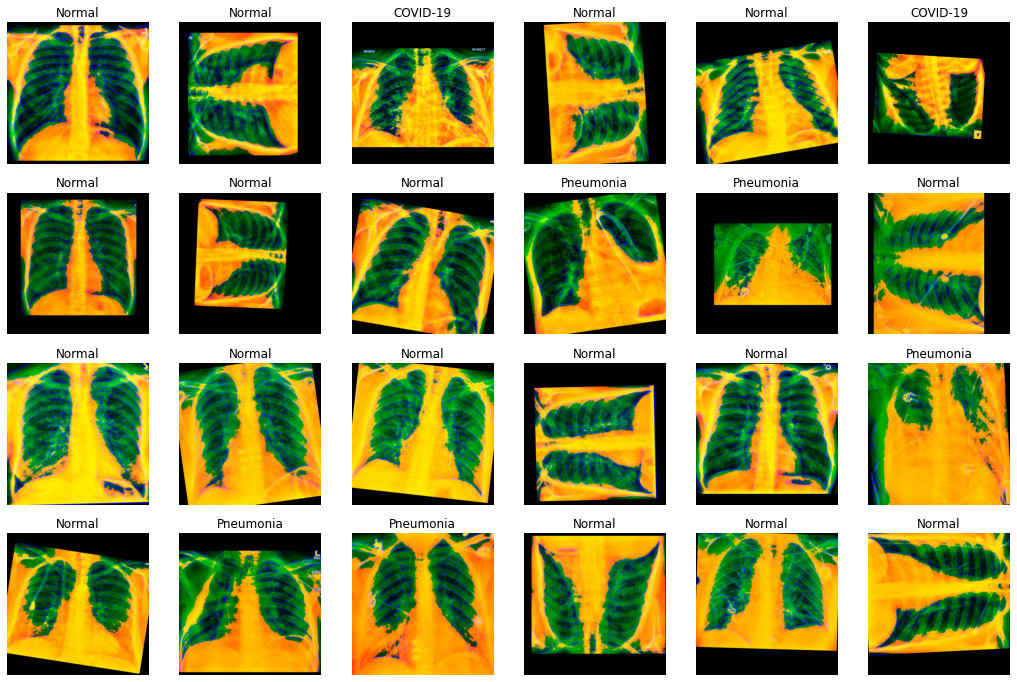

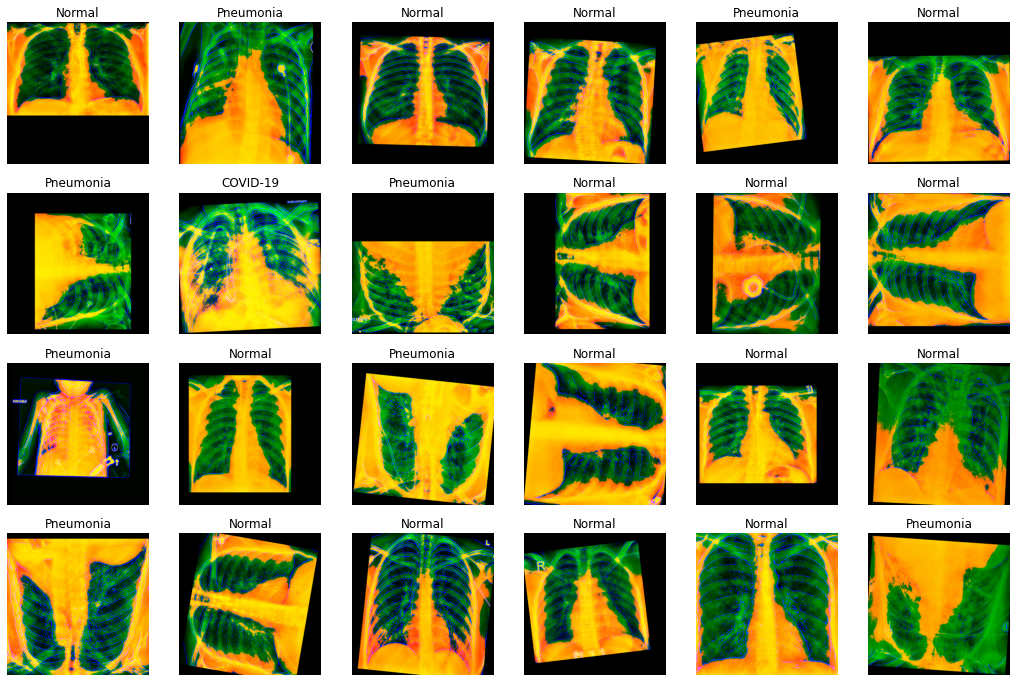

In [3]:
aug = aug_transforms(
  do_flip=True,
  flip_vert=True,
  max_rotate=10.,
  min_zoom=0.75,
  max_zoom=1.1,
  max_warp=0.0,
  pad_mode='zeros',
  xtra_tfms=[Normalize.from_stats(*imagenet_stats)]
)

cropper = InputCropper(regions_df)
def get_cropped_image(im_file):
    return cropper.get_cropped_image(str(im_file))

def get_sorted_image_files(path):
    return sorted(get_image_files(path))

datablock = DataBlock(
    blocks=(ImageBlock, CategoryBlock(vocab=["Normal", "Pneumonia", "COVID-19"])),
    get_items=get_sorted_image_files,
    item_tfms=Resize(size=(512, 512), method="pad", pad_mode='zeros'),
    batch_tfms=aug,
    get_x=get_cropped_image,
    get_y=parent_label
)

dls = datablock.dataloaders(train_dir, bs=24, seed=2020, valid_pct=0.1)
dls.show_batch(max_n=24)
dls.show_batch(max_n=24)

In [4]:
class_weights = torch.cuda.FloatTensor([3., 1., 1.])
learner = cnn_learner(dls, base_arch, wd=1e-2, loss_func=CrossEntropyLossFlat(weight=class_weights), path=model_path, model_dir=model_dir, metrics=accuracy)
if os.path.exists(os.path.join(model_path, model_dir, "best.pth")):
    learner.load("best")

learner.summary()

Sequential (Input shape: ['24 x 3 x 512 x 512'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               24 x 64 x 256 x 256  9,408      False     
________________________________________________________________
BatchNorm2d          24 x 64 x 256 x 256  128        True      
________________________________________________________________
ReLU                 24 x 64 x 256 x 256  0          False     
________________________________________________________________
MaxPool2d            24 x 64 x 128 x 128  0          False     
________________________________________________________________
Conv2d               24 x 64 x 128 x 128  36,864     False     
________________________________________________________________
BatchNorm2d          24 x 64 x 128 x 128  128        True      
________________________________________________________________
ReLU                 24 x 64 x 128 x 128  0          False     
_________________________________________________

Minimum/10: 7.59e-04, steepest point: 1.74e-03


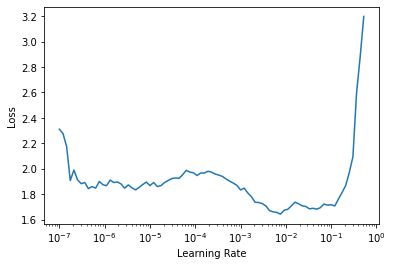

In [5]:
gc.collect()
lr_min, lr_steep = learner.lr_find() # find learning rate
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

In [6]:
callbacks = [
    SaveModelCallback(fname="best"),
    EarlyStoppingCallback(patience=8),
]
lr_1 = max(lr_steep, lr_min, 2.5e-3)
learner.fit_one_cycle(80, cbs=callbacks, lr_max=lr_1)
# learn.fit_one_cycle(50, cbs=callbacks, lr_max=1e-4)
gc.collect()

Better model found at epoch 0 with valid_loss value: 0.43346428871154785.
Better model found at epoch 1 with valid_loss value: 0.39943045377731323.
Better model found at epoch 2 with valid_loss value: 0.3316188454627991.
Better model found at epoch 3 with valid_loss value: 0.2857781648635864.
Better model found at epoch 5 with valid_loss value: 0.26610028743743896.
Better model found at epoch 6 with valid_loss value: 0.22334662079811096.
Better model found at epoch 7 with valid_loss value: 0.21251468360424042.
Better model found at epoch 12 with valid_loss value: 0.205143004655838.
Better model found at epoch 20 with valid_loss value: 0.16221442818641663.
No improvement since epoch 20: early stopping


13230

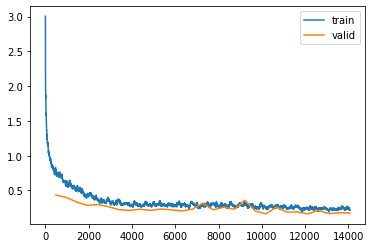

In [7]:
learner.recorder.plot_loss(0)

36

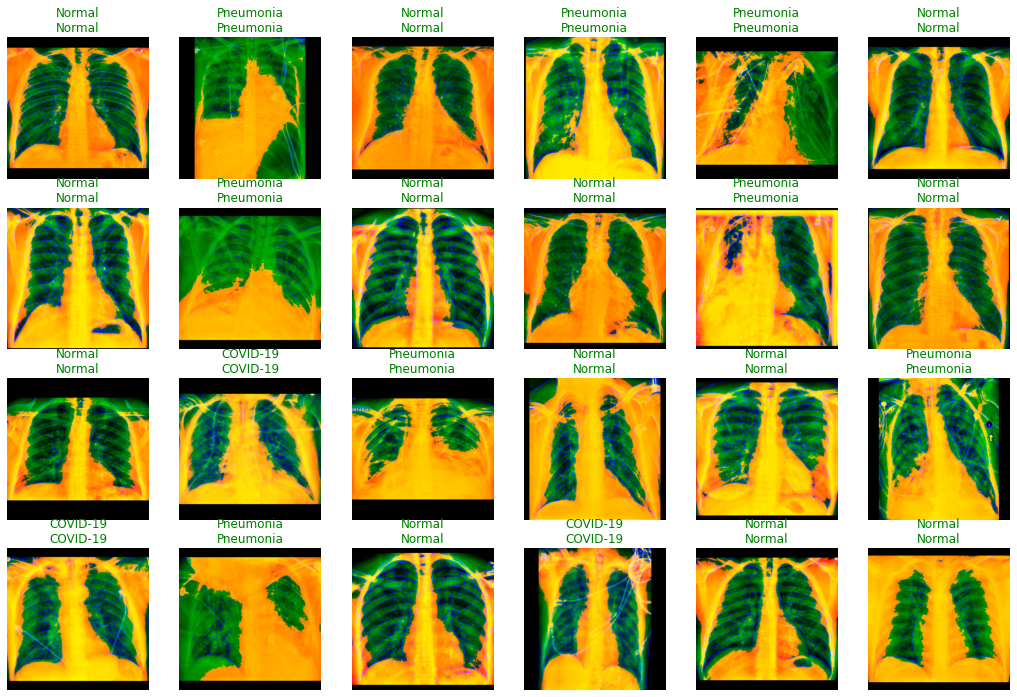

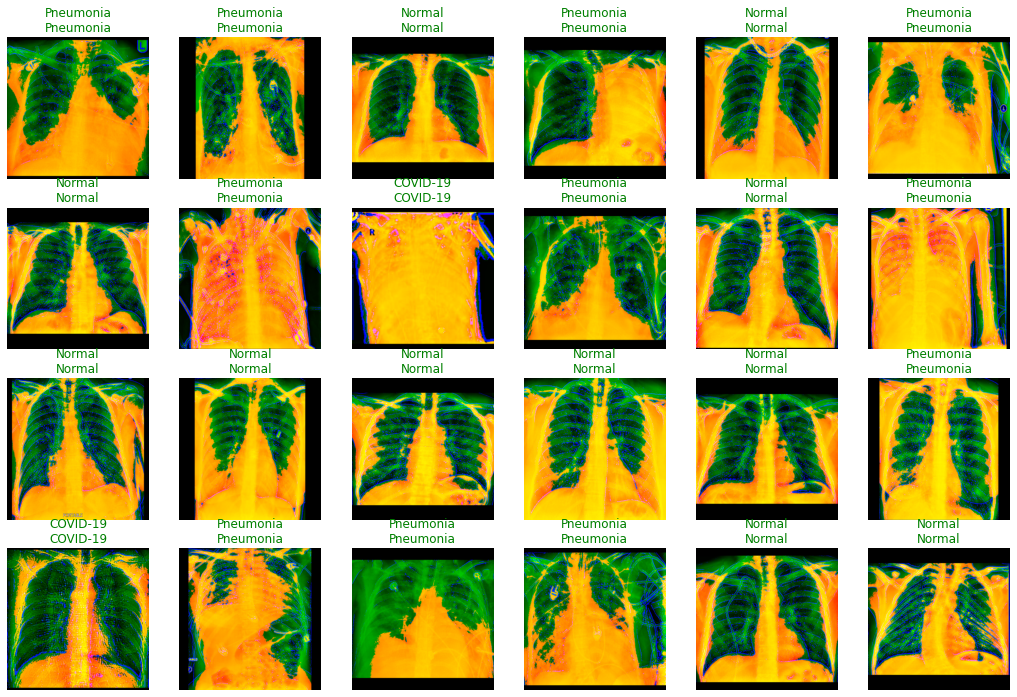

In [8]:
learner.load("best")
learner.show_results(max_n=24)
learner.show_results(max_n=24)
gc.collect()

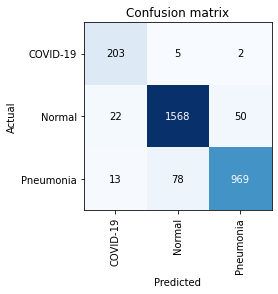

In [9]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()

In [10]:
# lr_min, lr_steep = learner.lr_find() # find learning rate
# print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

In [11]:
callbacks = [
    SaveModelCallback(fname="best-tuned"),
    EarlyStoppingCallback(patience=8),
]
learner.unfreeze()
learner.fit_one_cycle(80, cbs=callbacks, lr_max=slice(lr_1 / 1000., lr_1 / 10.), reset_opt=True)
# learner.fit_one_cycle(80, cbs=callbacks, lr_max=slice(lr_1 / 1000., lr_1), reset_opt=True)
# learner.fine_tune(80, base_lr=lr_1/10., cbs=callbacks, freeze_epochs=4, reset_opt=True)

Better model found at epoch 0 with valid_loss value: 0.1654461771249771.
Better model found at epoch 1 with valid_loss value: 0.1579619199037552.
Better model found at epoch 2 with valid_loss value: 0.15521293878555298.
Better model found at epoch 3 with valid_loss value: 0.154166579246521.
Better model found at epoch 4 with valid_loss value: 0.14585213363170624.
Better model found at epoch 10 with valid_loss value: 0.13810427486896515.
No improvement since epoch 10: early stopping


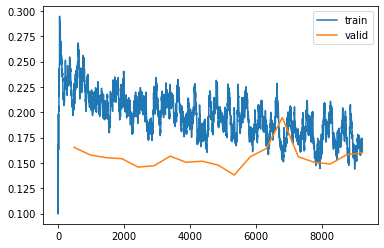

In [12]:
learner.recorder.plot_loss(0)

In [13]:
# TODO: change this to best-tuned
learner.load("best-tuned")
learner.freeze()
learner.export("classifier-model.pkl")

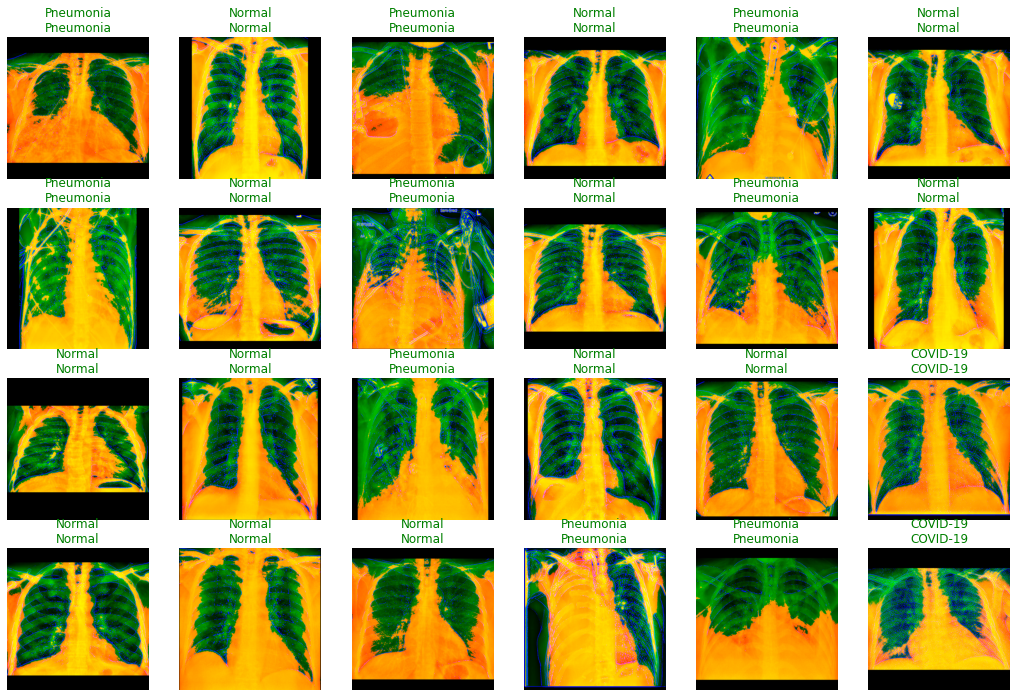

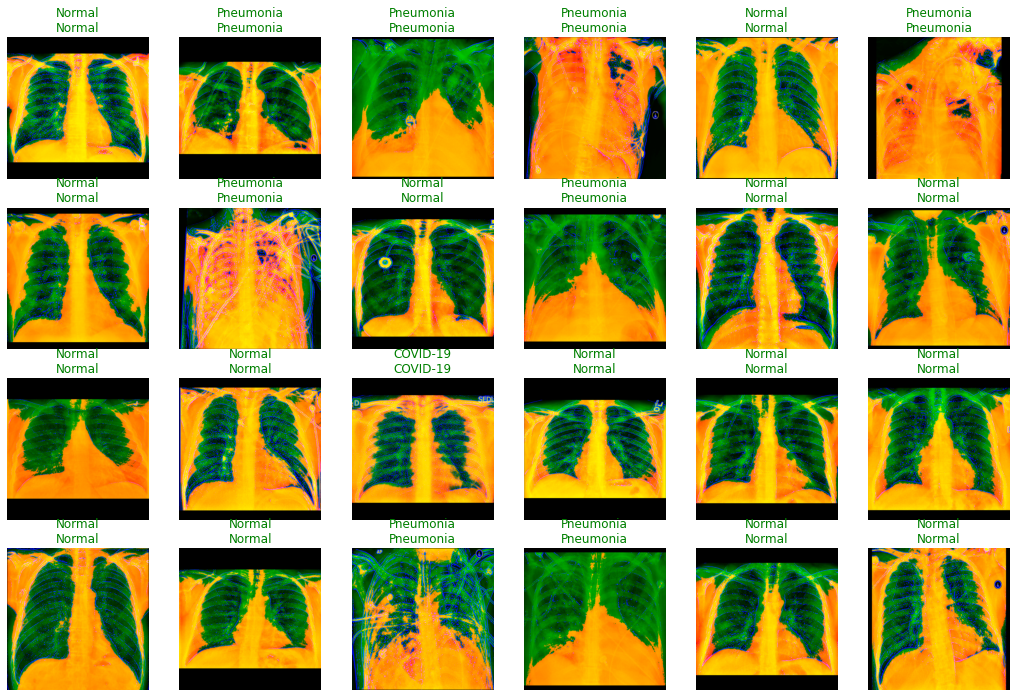

In [14]:
learner.show_results(max_n=24)
learner.show_results(max_n=24)

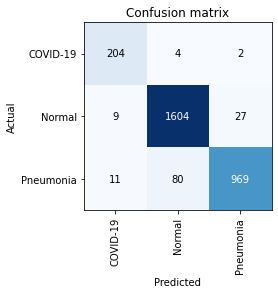

In [15]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()

In [16]:
from sklearn.metrics import confusion_matrix

gc.collect()
reverse_class_map = {v: i for i, v in enumerate(learner.dls.vocab)}

for test_dir in [data_dir/"evaluate", data_dir/"test"]:
    test_files = get_image_files(test_dir)
    n_files = len(test_files)
    step_size = 32
    p = []
    confidence = []
    
    for i in range(0, n_files, step_size):
        i_end = min(i+step_size, n_files)

        xray_files = test_files[i:i_end]
        dl = learner.dls.test_dl(xray_files, bs=16)
        preds, _, classes = learner.get_preds(dl=dl, with_input=False, with_decoded=True)
        conf = preds[np.arange(preds.shape[0]), classes]
        p.extend(classes.tolist())
        confidence.extend(conf.tolist())
        
#         print(f"{i_end} / {n_files}")
        gc.collect()
    
    y = regions_df.loc[[str(f) for f in test_files]]["class"].apply(lambda x: reverse_class_map[x])
#     print(y)
    print(test_dir)
    print(confusion_matrix(y, p, labels=[0,1,2]))

/data/datasets/extended_v2_Masked/evaluate
[[117   1   0]
 [  4  25   0]
 [  0   0   0]]


/data/datasets/extended_v2_Masked/test
[[ 93   4   3]
 [  4 863  18]
 [  5  46 543]]


In [17]:
from datetime import datetime as dt
import time

time.sleep(60)
# Save run as an HTML file
report_file = os.path.join(learner.path, learner.model_dir, "classifier-train_{:%Y%m%d_%H%M%S}.html".format(dt.now()))
print(f"Saving as: {report_file}")
os.system(f'jupyter nbconvert classifier-train.ipynb --to html --output {report_file}')

Saving as: /data/output/pytorch-extended_v2-20201027_02/resnet34/classifier-train_20201027_220638.html


0